# Transport Usage Prediction

**Team Members**:
- Timur Kasatkin
- Sergey Pinkevich

**Team name**: rzd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sklearn as skl
import sklearn
import pandas as pd
import scipy
import seaborn as sns

In [4]:
rcParams['figure.figsize'] = (5,3)

In [5]:
train_df = pd.read_csv(
    "train.csv",
    parse_dates=["date"],
    dtype={
        "hour": int8,
        "holiday": bool,
        "workingday": bool,
        "weekday": int8,
        "weather_type": int8
    })
train_df.head()

,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,humidity,wind_speed,casual,subscribed,usage
0,2011-01-03,0,False,True,1,1,0.22,0.19699999999999998,0.44,0.3582,0,15,15
1,2011-01-03,1,False,True,1,1,0.20,0.1667,0.44,0.4179,0,6,6
2,2011-01-03,4,False,True,1,1,0.16,0.1364,0.47,0.3881,0,3,3
3,2011-01-03,5,False,True,1,1,0.16,0.1364,0.47,0.2836,0,9,9
4,2011-01-03,6,False,True,1,1,0.14,-,0.50,0.3881,0,90,90


# 1. Data investigation

### Correlation

In [6]:
train_df.corr()[:"wind_speed"]

,hour,holiday,workingday,weekday,weather_type,temp,humidity,wind_speed,casual,subscribed,usage
hour,1.000000,0.000468,0.002209,-0.003679,-0.029682,0.131916,-0.271771,0.127540,0.028011,0.371302,0.098023
holiday,0.000468,1.000000,-0.247877,-0.094536,-0.013434,-0.008131,0.006655,-0.019608,0.002130,-0.041417,-0.005842
workingday,0.002209,-0.247877,1.000000,0.036898,0.057356,0.053103,0.025730,-0.004804,-0.015372,0.134013,0.010684
weekday,-0.003679,-0.094536,0.036898,1.000000,0.000816,0.000837,-0.043147,0.025951,-0.000206,0.015390,0.002738
weather_type,-0.029682,-0.013434,0.057356,0.000816,1.000000,-0.083150,0.417010,0.044447,-0.015864,-0.131915,-0.040555
temp,0.131916,-0.008131,0.053103,0.000837,-0.083150,1.000000,-0.032506,-0.035742,0.040763,0.332923,0.103055
humidity,-0.271771,0.006655,0.025730,-0.043147,0.417010,-0.032506,1.000000,-0.282958,-0.036357,-0.268173,-0.086425
wind_speed,0.127540,-0.019608,-0.004804,0.025951,0.044447,-0.035742,-0.282958,1.000000,0.010544,0.080219,0.025531


### Plots

In [7]:
print(train_df.pivot_table(values='casual',index='holiday'),\
     train_df.pivot_table(values='subscribed',index='holiday'),\
     train_df.pivot_table(values='usage',index='holiday'),sep='\n')

holiday
False    175.949792
True     206.072829
Name: casual, dtype: float64
holiday
False    461.585134
True     346.218487
Name: subscribed, dtype: float64
holiday
False    637.534926
True     552.291317
Name: usage, dtype: float64


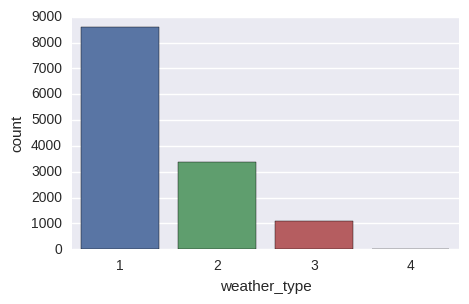

In [14]:
sns.countplot(train_df.weather_type);

### Casual

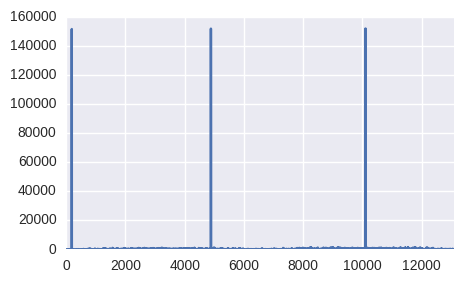

In [8]:
train_df.casual.plot();

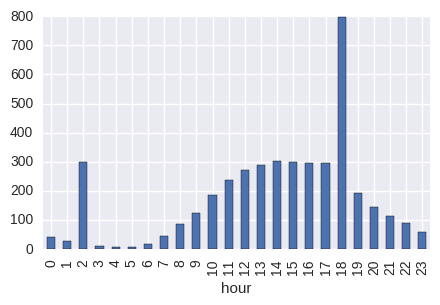

In [22]:
train_df.pivot_table(values='casual',index='hour',aggfunc=np.mean).plot.bar();

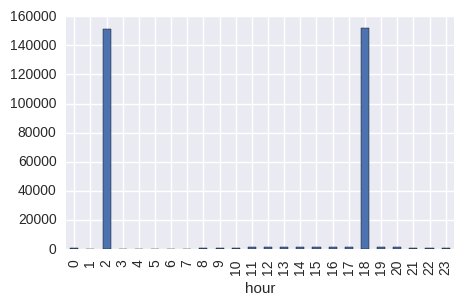

In [23]:
train_df.pivot_table(values='casual',index='hour',aggfunc=np.max).plot.bar();

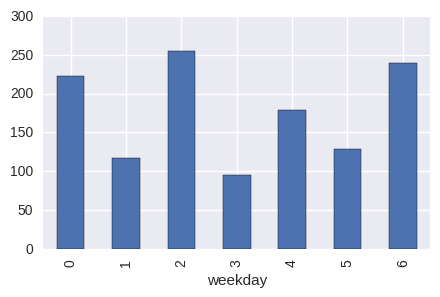

In [23]:
train_df.pivot_table(values='casual', index='weekday', aggfunc=np.mean).plot.bar();

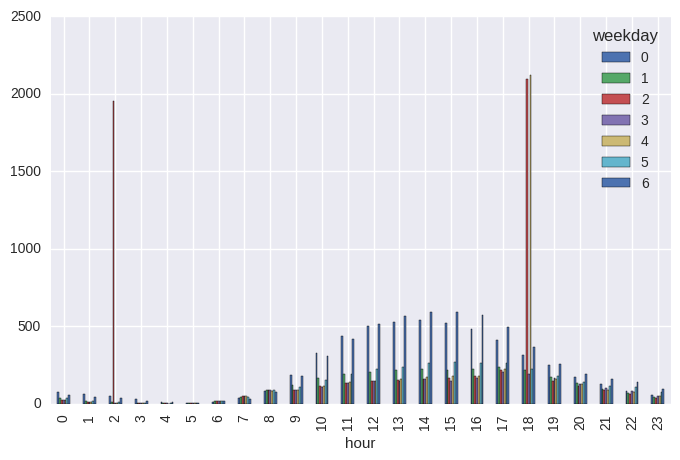

In [28]:
train_df.pivot_table(values='casual', index='hour', columns='weekday', aggfunc=np.mean).plot.bar(figsize=(8,5));

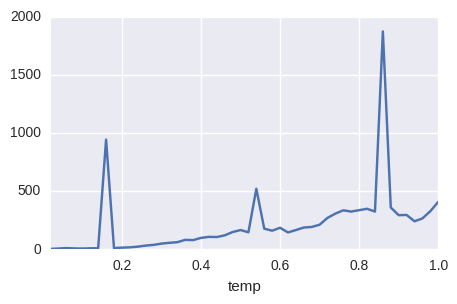

In [30]:
train_df.pivot_table(values='casual', index='temp', aggfunc=np.mean).plot();

### Subscribed

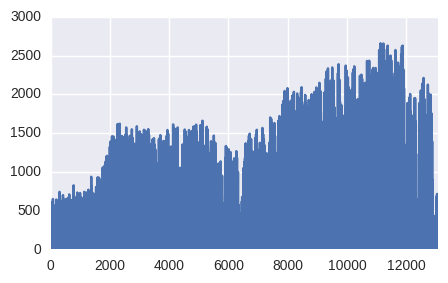

In [11]:
train_df.subscribed.plot();

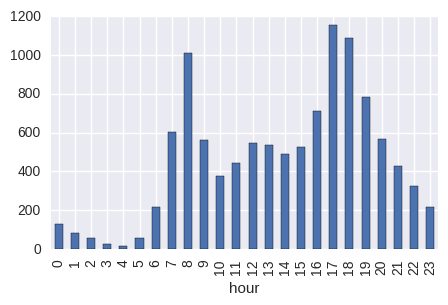

In [15]:
train_df.pivot_table(values='subscribed', index='hour', aggfunc=np.mean).plot.bar();

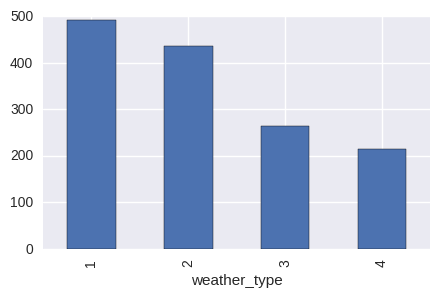

In [25]:
train_df.pivot_table(values='subscribed', index='weather_type', aggfunc=np.mean).plot.bar();

# 2. Data Preprocessing

### date

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
date_scaler = MinMaxScaler()
train_df.date = date_scaler.fit_transform(train_df.date.astype(int)[:,newaxis])

/home/timur/dev_ides/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


### ftemp

In [15]:
ftemp_nonna_df = train_df[train_df.ftemp != '-']
ftemp_mean_diff = (ftemp_nonna_df.temp - ftemp_nonna_df.ftemp.astype(float)).mean()

train_df["ftemp_mean_diff"] = train_df.ftemp
train_df.loc[train_df.ftemp == '-', 'ftemp_mean_diff'] = train_df.temp - ftemp_mean_diff
train_df.ftemp_mean_diff = train_df.ftemp_mean_diff.astype(float)

train_df = pd.concat([train_df.loc[:,:"ftemp"], train_df.ftemp_mean_diff, train_df.loc[:,"humidity":"usage"]],axis=1)

In [16]:
train_df.head()

,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,ftemp_mean_diff,humidity,wind_speed,casual,subscribed,usage
0,0.0,0,False,True,1,1,0.22,0.19699999999999998,0.197000,0.44,0.3582,0,15,15
1,0.0,1,False,True,1,1,0.20,0.1667,0.166700,0.44,0.4179,0,6,6
2,0.0,4,False,True,1,1,0.16,0.1364,0.136400,0.47,0.3881,0,3,3
3,0.0,5,False,True,1,1,0.16,0.1364,0.136400,0.47,0.2836,0,9,9
4,0.0,6,False,True,1,1,0.14,-,0.119043,0.50,0.3881,0,90,90


### Data forming

In [18]:
def extract_train(df, as_matrix=True):
    discrete = df[["hour","holiday","workingday","weekday"]]
    continious = df[["date","temp","ftemp_mean_diff","humidity","wind_speed"]]
    X_train = pd.concat((continious, discrete),axis=1)
    y_subscribed_train = df.subscribed.astype(int)
    y_casual_train = df.casual.astype(int)
    y_usage_train = df.usage.astype(int)
    if as_matrix:
        return X_train.as_matrix(), \
                y_subscribed_train.as_matrix(), \
                y_casual_train.as_matrix(), \
                y_usage_train.as_matrix()
    return X_train, y_subscribed_train, y_casual_train, y_usage_train

# 3. Model Selection

In [92]:
pd.options.display.float_format = '{:,.3f}'.format

In [19]:
X_train, y_subscribed_train, y_casual_train, y_usage_train = extract_train(train_df,as_matrix=True)

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import NuSVR,LinearSVR,SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [46]:
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

In [47]:
def MAE(est,X,y):
    return mean_absolute_error(y,est.predict(X))

def NegMAE(est,X,y):
    return -MAE(est,X,y)

def R2(est,X,y):
    return r2_score(y,est.predict(X))

In [48]:
def cross_validation_scores(clf, X, y, n_splits = 10, scores = [MAE, R2],output=True):
    kf = KFold(n_splits=n_splits,shuffle=True)
    final = []
    
    for train_inds, test_inds in kf.split(X):
        X_train, y_train = X[train_inds], y[train_inds]
        clf.fit(X_train, y_train)
        X_test, y_test = X[test_inds], y[test_inds]
        res = []
        for score in scores:
            sc = score(clf,X_test,y_test)
            res.append(sc)
            if output:
                print(score.__name__,sc,sep=' : ',end='; ')
        final.append(tuple(res))
        if output:
            print()
    return tuple(np.array(z) for z in zip(*final))

In [40]:
clfs = [DecisionTreeRegressor(),NuSVR(),LinearSVR(),SVR(),\
        KNeighborsRegressor(),SGDRegressor(),RandomForestRegressor()]

In [67]:
first_scores_df = pd.DataFrame(columns=pd.MultiIndex.from_arrays(\
                                                 [['Subscribed','Subscribed','Casual','Casual','Usage','Usage'],\
                                                  ['MAE','R2','MAE','R2','MAE','R2']]))

In [ ]:
for clf in clfs:
    subscribed_maes, subscribed_r2s = cross_validation_scores(clf,X_train,y_subscribed_train,output=False)
    casual_maes, casual_r2s = cross_validation_scores(clf,X_train,y_casual_train,output=False)
    usage_maes, usage_r2s = cross_validation_scores(clf,X_train, y_usage_train, output=False)
    first_scores_df.loc[type(clf).__name__] = (subscribed_maes.mean(),subscribed_r2s.mean(),\
                                               casual_maes.mean(),casual_r2s.mean(),\
                                               usage_maes.mean(),usage_r2s.mean())

In [93]:
first_scores_df

Subscribed        Casual           Usage       
                             MAE    R2     MAE      R2     MAE     R2
DecisionTreeRegressor     84.744 0.889 104.087 -91.047 163.005 -4.630
NuSVR                    234.188 0.405 125.718   0.263 363.947  0.263
LinearSVR                254.630 0.230 124.888   0.217 365.964  0.205
SVR                      206.942 0.422 117.613   0.338 322.744  0.310
KNeighborsRegressor       87.611 0.887 118.137 -18.712 194.932 -2.091
SGDRegressor             284.286 0.286 152.678   0.084 378.298  0.292
RandomForestRegressor     66.532 0.935 106.597 -19.978 162.028 -1.401

In [84]:
casual_df = train_df.copy()
subscribed_df = train_df.copy()

## Model tuning

### Outliers removal

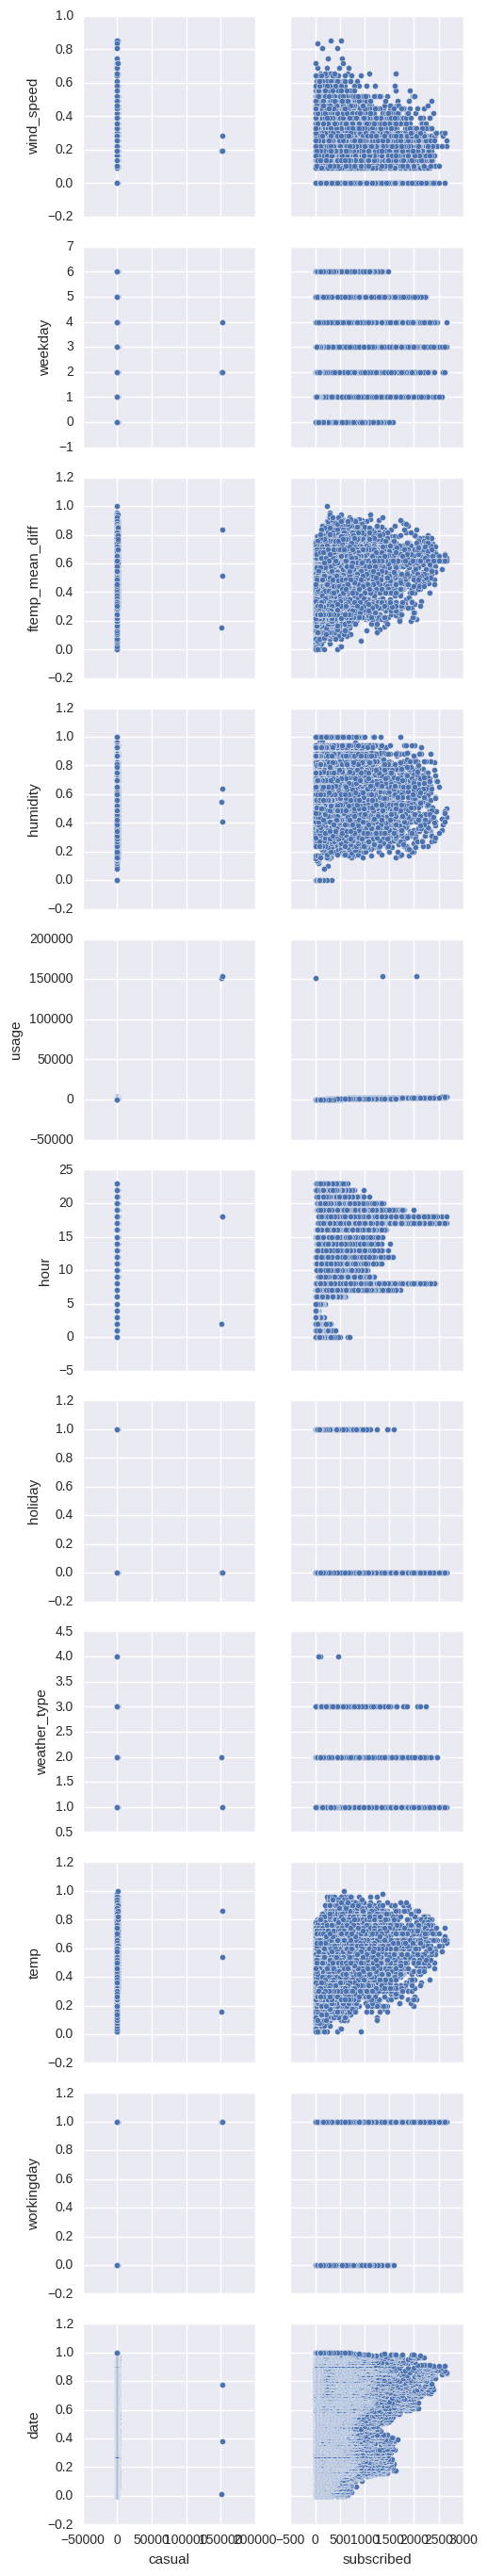

In [39]:
sns.pairplot(train_df,x_vars=['casual','subscribed'],y_vars=set(train_df.columns)-{'casual','subscribed','ftemp'});

#### Casual

In [44]:
casual_df.describe(percentiles=[.25,.5,.75,.9,.95,.99,.995,.998,.999])['casual']

count     13084.000000
mean        176.771706
std        2303.968546
min           0.000000
25%          16.000000
50%          64.000000
75%         192.000000
90%         368.000000
95%         556.000000
99%         952.000000
99.5%      1062.340000
99.8%      1207.336000
99.9%      1300.000000
max      151915.000000
Name: casual, dtype: float64

In [57]:
clf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
cv = KFold(n_splits=10,shuffle=True)

In [74]:
def mean_r2(df):
    X_casual_train, _, y_casual_train, _ = extract_train(df,as_matrix=True)
    return cross_val_score(clf, X_casual_train, y_casual_train, cv=cv,scoring='r2',n_jobs=-1).mean()

In [78]:
mean_r2(casual_df)

-45.960133491713862

In [100]:
mean_r2(casual_df[casual_df.casual < 10000])

0.91793973403355955

In [67]:
train_casual_df = casual_df[casual_df.casual < 10000]

In [82]:
mean_r2(casual_df[~((casual_df.workingday == 1) & (casual_df.casual > 1000))])

0.9139078751984242

In [83]:
mean_r2(casual_df[~((casual_df.weekday == 3) & (casual_df.casual > 800))])

-39.914812053054973

In [88]:
mean_r2(casual_df[~(((casual_df.weather_type == 3) & (casual_df.casual > 800)) | \
                   ((casual_df.weather_type == 4) & (casual_df.casual > 1200)))])

0.91600347435136309

In [94]:
mean_r2(casual_df[casual_df.wind_speed <= 0.85])

0.91592006741429643

In [95]:
mean_r2(casual_df[casual_df.weather_type != 4])

0.91659653877215774

In [97]:
mean_r2(casual_df[(0.1 <= casual_df.temp) & (casual_df.temp <= 0.9)])

0.91449677734235979

In [98]:
mean_r2(casual_df[~((casual_df.workingday == 1) & (casual_df.casual > 1000))])

0.91654978525871711

##### Profit

- leave only casual < 10000

##### Do not help

- removal of working_day = 1 and casual > 1000
- removal of weekday = 3 and casual > 800
- removal of (weather_type = 3 and casual > 800) and (weather_type = 4 and casual > 1200)
- removal wind_speed > 0.85 
- removal of weather_type = 4 (there is only 3 such tuples)
- removal of temp < 0.1 and temp > 0.9
- removal of workingday = 1 and casual > 1000

### Subscribed

In [101]:
X_subscribed_train, y_subscribed_train, _, _ = extract_train(subscribed_df)

In [122]:
for n_est in range(200,300,10):
    scores = cross_val_score(RandomForestRegressor(n_estimators=n_est,n_jobs=-1), \
                                     X_train, y_subscribed_train, scoring='r2', n_jobs=-1, cv=cv)
    print("For n_est=%d :" % n_est, "R2:", scores.mean())

For n_est=200 : R2: 0.939926563832
For n_est=210 : R2: 0.939746038418
For n_est=220 : R2: 0.940425535913
For n_est=230 : R2: 0.93963050926
For n_est=240 : R2: 0.94064818669
For n_est=250 : R2: 0.938848958195
For n_est=260 : R2: 0.940283265422
For n_est=270 : R2: 0.939913017628
For n_est=280 : R2: 0.939475640393
For n_est=290 : R2: 0.942021821506


In [124]:
for i in range(1,10):
    scores = cross_val_score(RandomForestRegressor(n_estimators=270,max_features=i,n_jobs=-1), \
                                     X_train, y_subscribed_train, scoring='r2', n_jobs=-1, cv=cv)
    print("For max_features=%d :" % i, "R2:", scores.mean())

For max_features=1 : R2: 0.793894288581
For max_features=2 : R2: 0.879083546614
For max_features=3 : R2: 0.925264871079
For max_features=4 : R2: 0.942397537406
For max_features=5 : R2: 0.946951606298
For max_features=6 : R2: 0.946871772759
For max_features=7 : R2: 0.944703138209
For max_features=8 : R2: 0.943062524152
For max_features=9 : R2: 0.940073429783


### Casual

In [104]:
train_casual_df = train_df[train_df.casual < 10000]

In [105]:
X_casual_train, _, y_casual_train, _ = extract_train(train_casual_df)

In [111]:
results = []
for n_est in range(200,300,10):
    scores = cross_validation_scores(RandomForestRegressor(n_estimators=n_est,n_jobs=-1), \
                                     X_casual_train, y_casual_train,\
                                    scores=[MAE,R2], output=False)
    results.append(scores[1].mean())
    print("For n_est=%d :" % n_est,"MAE:",scores[0].mean(),";","R2:", scores[1].mean())

For n_est=200 : MAE: 33.0790162051 ; R2: 0.916583590308
For n_est=210 : MAE: 33.0971380145 ; R2: 0.917153400458
For n_est=220 : MAE: 33.1067294896 ; R2: 0.916073628751
For n_est=230 : MAE: 32.9764950982 ; R2: 0.91829618165
For n_est=240 : MAE: 32.9606187764 ; R2: 0.917648886224
For n_est=250 : MAE: 32.9652875847 ; R2: 0.917966815538
For n_est=260 : MAE: 33.0891449385 ; R2: 0.91648191744
For n_est=270 : MAE: 32.8381271066 ; R2: 0.91843949762
For n_est=280 : MAE: 32.8451285961 ; R2: 0.917784835165
For n_est=290 : MAE: 32.9420387301 ; R2: 0.917653571926


In [117]:
for i in range(1,10):
    scores = cross_validation_scores(RandomForestRegressor(n_estimators=270,max_features=i,n_jobs=-1), \
                                     X_casual_train, y_casual_train,\
                                    scores=[MAE,R2], output=False)
    print("For max_features=%d :" % i,"MAE:",scores[0].mean(),";","R2:", scores[1].mean())

For max_features=1 : MAE: 39.636374992 ; R2: 0.881607298654
For max_features=2 : MAE: 35.7859867442 ; R2: 0.902998355252
For max_features=3 : MAE: 33.6651545272 ; R2: 0.914611082353
For max_features=4 : MAE: 32.9953115692 ; R2: 0.917952663821
For max_features=5 : MAE: 32.7741714359 ; R2: 0.919044754785
For max_features=6 : MAE: 32.730906058 ; R2: 0.919221017481
For max_features=7 : MAE: 32.7901768038 ; R2: 0.918289572782
For max_features=8 : MAE: 32.819947784 ; R2: 0.918857489003
For max_features=9 : MAE: 32.8704771133 ; R2: 0.917878545261


# 4. Prediction

In [125]:
casual_clf = RandomForestRegressor(n_estimators=270, max_features=6, n_jobs=-1)
casual_clf.fit(X_casual_train, y_casual_train)
subscribed_clf = RandomForestRegressor(n_estimators=270, max_features=6, n_jobs=-1)
subscribed_clf.fit(X_subscribed_train, y_subscribed_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=270, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [126]:
test_df = pd.read_csv('test.csv',\
                      parse_dates=["date"],\
                      dtype={
                          "hour": int8,
                          "holiday": bool,
                          "workingday": bool,
                          "weekday": int8,
                          "weather_type": int8
                      })
test_df.head()

,Id,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,humidity,wind_speed
0,0,2011-01-01,0,False,False,6,1,0.24,-,0.81,0.0
1,1,2011-01-01,1,False,False,6,1,0.22,0.2727,0.80,0.0
2,2,2011-01-01,2,False,False,6,1,0.22,-,0.80,0.0
3,3,2011-01-01,3,False,False,6,1,0.24,0.2879,0.75,0.0
4,4,2011-01-01,4,False,False,6,1,0.24,0.2879,0.75,0.0


In [127]:
test_df["date"] = date_scaler.transform(test_df.date.astype(int)[:,newaxis])

In [128]:
test_df["ftemp_mean_diff"] = test_df.ftemp
test_df.loc[test_df.ftemp == '-', 'ftemp_mean_diff'] = test_df.temp - ftemp_mean_diff
test_df["ftemp_mean_diff"] = test_df.ftemp_mean_diff.astype(float)

In [129]:
test_df.head()

,Id,date,hour,holiday,workingday,weekday,weather_type,temp,ftemp,humidity,wind_speed,ftemp_mean_diff
0,0,-0.002755,0,False,False,6,1,0.24,-,0.81,0.0,0.219043
1,1,-0.002755,1,False,False,6,1,0.22,0.2727,0.80,0.0,0.272700
2,2,-0.002755,2,False,False,6,1,0.22,-,0.80,0.0,0.199043
3,3,-0.002755,3,False,False,6,1,0.24,0.2879,0.75,0.0,0.287900
4,4,-0.002755,4,False,False,6,1,0.24,0.2879,0.75,0.0,0.287900


In [130]:
X_test = scipy.hstack((test_df[["date","temp","ftemp_mean_diff","humidity","wind_speed"]].as_matrix(),\
                       pd.concat([test_df.hour, test_df.holiday, test_df.workingday, test_df.weekday],axis=1).as_matrix()))

In [131]:
res = scipy.hstack([test_df.Id.as_matrix()[:,newaxis],\
                    (casual_clf.predict(X_test) + subscribed_clf.predict(X_test))[:,newaxis]])

In [134]:
res_df = pd.DataFrame(data=res,columns=['Id','Expected'])
res_df.Id = res_df.Id.astype(int)

In [135]:
res_df.to_csv('submission.csv',index=False)